# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).


**Note**: Make sure you make a validation split of your ID dataset for testing.

In [1]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision.datasets import FakeData, DatasetFolder

from sklearn import metrics
from sklearn.metrics import roc_auc_score


In [3]:
SEED = 42 # seed for random number generation
torch.manual_seed(SEED) # pytorch random generator --> affects model initialization, dropout, etc.
np.random.seed(SEED) # numpy random generator --> affects data shuffling, etc.
random.seed(SEED) # python random generator --> affects data shuffling, etc. (e.g., in sklearn)
torch.use_deterministic_algorithms(True) # ensures that the results are reproducible --> deterministic
torch.backends.cudnn.deterministic = True 


In [4]:
torch.cuda.is_available()

True

In [5]:
# Load and normalize CIFAR10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers= True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers= True)
# Create fake data loader
fakeset = FakeData(size=1000, image_size=(3, 32, 32), transform=transform) # create a fake dataset of 1000 random images
fakeloader = torch.utils.data.DataLoader(fakeset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers= True)

100%|██████████| 170M/170M [00:11<00:00, 15.5MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

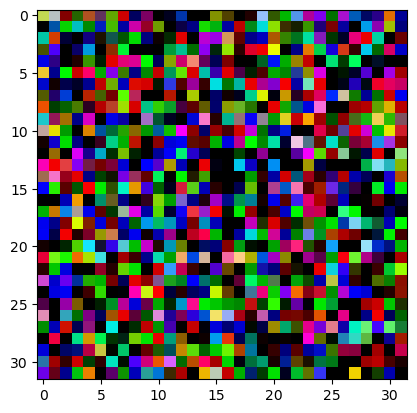

In [6]:
# Visualize a sample ftom the fake dataset
for data in fakeloader:
    x, y = data
    plt.imshow(x[0,:].permute(1,2,0))
    break

x.shape, trainset.classes[y[0]]

trainset.classes #cifar10 classes
class_dict = {class_name:id_class for id_class, class_name in enumerate(trainset.classes)} #dictionary of class names and their corresponding ids
class_dict #print the class dictionary

In [7]:
x.shape, trainset.classes[y[0]] #print the shape of the first image and its class name

(torch.Size([128, 3, 32, 32]), 'horse')

In [8]:
# A very simple CNN model.
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
# A more complex CNN model.
class DeepCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)  # downsample
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # downsample
        
        self.flatten_dim = 256 * 8 * 8  # assuming input is 32x32
        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # -> 32x32x32
        x = F.relu(self.conv2(x))   # -> 32x32x64
        x = F.relu(self.conv3(x))   # -> 32x32x128
        x = F.relu(self.conv4(x))   # -> 16x16x128
        x = F.relu(self.conv5(x))   # -> 8x8x256
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# load the model onto the GPU if available
model = DeepCNN().to(device)

loss =  nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)


In [11]:
load_resnet = False
load = False
# Train the model
if not load_resnet and not load:
    epochs = 50
    for e in range(epochs):
        running_loss = 0
        for it, data in enumerate (trainloader):
            x, y = data
            x, y = x.to(device), y.to(device)
            
            yp = model(x)
            l = loss(yp, y)
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            running_loss += l.item()
            #if it % 100 == 0:
            #    print(it, l.item())
        print(f"epoch: {e}, loss: {running_loss/len(trainloader):.4f}, lr: {optimizer.param_groups[0]['lr']}")
    torch.save(model.state_dict(), f'./cifar10_CNN_{epochs}_{optimizer.param_groups[0]["lr"]}.pth')      

epoch: 0, loss: 1.8106, lr: 0.0001
epoch: 1, loss: 1.4630, lr: 0.0001
epoch: 2, loss: 1.3140, lr: 0.0001
epoch: 3, loss: 1.2071, lr: 0.0001
epoch: 4, loss: 1.1292, lr: 0.0001
epoch: 5, loss: 1.0515, lr: 0.0001
epoch: 6, loss: 0.9730, lr: 0.0001
epoch: 7, loss: 0.9022, lr: 0.0001
epoch: 8, loss: 0.8236, lr: 0.0001
epoch: 9, loss: 0.7486, lr: 0.0001
epoch: 10, loss: 0.6726, lr: 0.0001
epoch: 11, loss: 0.5870, lr: 0.0001
epoch: 12, loss: 0.5000, lr: 0.0001
epoch: 13, loss: 0.4120, lr: 0.0001
epoch: 14, loss: 0.3185, lr: 0.0001
epoch: 15, loss: 0.2479, lr: 0.0001
epoch: 16, loss: 0.1765, lr: 0.0001
epoch: 17, loss: 0.1283, lr: 0.0001
epoch: 18, loss: 0.0972, lr: 0.0001
epoch: 19, loss: 0.0768, lr: 0.0001
epoch: 20, loss: 0.0797, lr: 0.0001
epoch: 21, loss: 0.0555, lr: 0.0001
epoch: 22, loss: 0.0551, lr: 0.0001
epoch: 23, loss: 0.0426, lr: 0.0001
epoch: 24, loss: 0.0428, lr: 0.0001
epoch: 25, loss: 0.0514, lr: 0.0001
epoch: 26, loss: 0.0391, lr: 0.0001
epoch: 27, loss: 0.0449, lr: 0.0001
ep

In [12]:
simple_model = SimpleCNN().to(device)
if not load_resnet and not load:
    epochs = 50
    for e in range(epochs):
        running_loss = 0
        for it, data in enumerate (trainloader):
            x, y = data
            x, y = x.to(device), y.to(device)
            
            yp = simple_model(x)
            l = loss(yp, y)
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            running_loss += l.item()
            #if it % 100 == 0:
            #    print(it, l.item())
        print(f"epoch: {e}, loss: {running_loss/len(trainloader):.4f}, lr: {optimizer.param_groups[0]['lr']}")
    torch.save(simple_model.state_dict(), f'./cifar10_CNN_{epochs}_{optimizer.param_groups[0]["lr"]}.pth')

epoch: 0, loss: 2.3048, lr: 0.0001
epoch: 1, loss: 2.3048, lr: 0.0001
epoch: 2, loss: 2.3048, lr: 0.0001
epoch: 3, loss: 2.3048, lr: 0.0001
epoch: 4, loss: 2.3048, lr: 0.0001
epoch: 5, loss: 2.3048, lr: 0.0001
epoch: 6, loss: 2.3048, lr: 0.0001
epoch: 7, loss: 2.3048, lr: 0.0001
epoch: 8, loss: 2.3048, lr: 0.0001
epoch: 9, loss: 2.3048, lr: 0.0001
epoch: 10, loss: 2.3048, lr: 0.0001
epoch: 11, loss: 2.3048, lr: 0.0001
epoch: 12, loss: 2.3048, lr: 0.0001
epoch: 13, loss: 2.3048, lr: 0.0001
epoch: 14, loss: 2.3048, lr: 0.0001
epoch: 15, loss: 2.3048, lr: 0.0001
epoch: 16, loss: 2.3048, lr: 0.0001
epoch: 17, loss: 2.3048, lr: 0.0001
epoch: 18, loss: 2.3048, lr: 0.0001
epoch: 19, loss: 2.3048, lr: 0.0001
epoch: 20, loss: 2.3048, lr: 0.0001
epoch: 21, loss: 2.3048, lr: 0.0001
epoch: 22, loss: 2.3048, lr: 0.0001
epoch: 23, loss: 2.3048, lr: 0.0001
epoch: 24, loss: 2.3048, lr: 0.0001
epoch: 25, loss: 2.3048, lr: 0.0001
epoch: 26, loss: 2.3048, lr: 0.0001
epoch: 27, loss: 2.3048, lr: 0.0001
ep

In [ ]:
# load and evaluate the pretrained model
if load:
    model = SimpleCNN().to(device)
    model.load_state_dict(torch.load('./cifar10_CNN.pth'))
    y_gt, y_pred = [], []
    for it, data in enumerate (testloader):
        x, y = data
        x, y = x.to(device), y.to(device)

        yp = model(x)

        y_pred.append(yp.argmax(1))
        y_gt.append(y)

    y_pred_t = torch.cat(y_pred)
    y_gt_t = torch.cat(y_gt)

    accuracy = sum(y_pred_t == y_gt_t)/len(y_gt_t)
    print(f'Accuracy: {accuracy}')

    cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())

    cmn = cm.astype(np.float32)
    cmn/=cmn.sum(1)

    cmn = (100*cmn).astype(np.int32)
    disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=testset.classes)
    disp.plot()
    plt.show()
    cmn = cm.astype(np.float32)
    cmn/=cmn.sum(1)
    print(f'Per class accuracy: {np.diag(cmn).mean():.4f}')

/tmp/ipykernel_4513/828887696.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./cifar10_CNN_50_0.0001.pth')) #fully trained


Accuracy: 0.6686999797821045


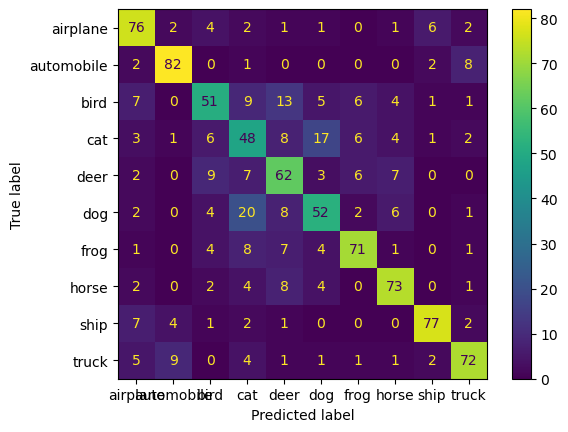

Per class accuracy: 0.6687


In [ ]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL (deep cnn).
#load = True
if load:
    model = DeepCNN().to(device)
    model.load_state_dict(torch.load('./cifar10_CNN_50_0.0001.pth')) #fully trained
    #model.load_state_dict(torch.load(f'./cifar10_CNN_{epochs}_{optimizer.param_groups[0]["lr"]}.pth'))
    y_gt, y_pred = [], []
    for it, data in enumerate (testloader):
        x, y = data
        x, y = x.to(device), y.to(device)

        yp = model(x)

        y_pred.append(yp.argmax(1))
        y_gt.append(y)

    y_pred_t = torch.cat(y_pred)
    y_gt_t = torch.cat(y_gt)

    accuracy = sum(y_pred_t == y_gt_t)/len(y_gt_t)
    print(f'Accuracy: {accuracy}')

    cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())

    cmn = cm.astype(np.float32)
    cmn/=cmn.sum(1)

    cmn = (100*cmn).astype(np.int32)
    disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=testset.classes)
    disp.plot()
    plt.show()
    cmn = cm.astype(np.float32)
    cmn/=cmn.sum(1)
    print(f'Per class accuracy: {np.diag(cmn).mean():.4f}')

/home/eledaveri/miniconda3/envs/labs/lib/python3.10/site-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /home/eledaveri/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /home/eledaveri/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|

Accuracy: 0.6189000010490417


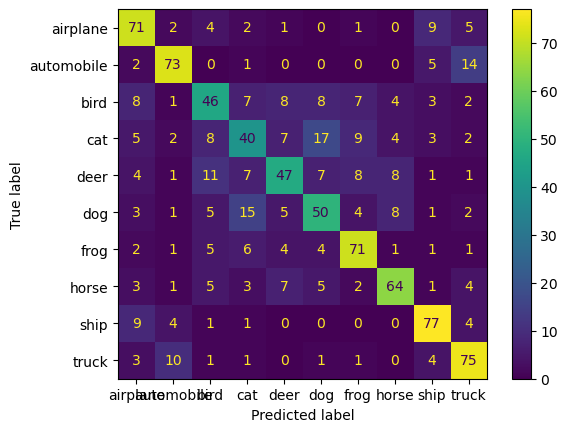

Per class accuracy: 0.6189


In [14]:
# USE THIS CELL TO LOAD THE PRETRAINED RESNET.
load_resnet = True
if load_resnet:
    model_resnet = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
    model_resnet.eval()
    model_resnet.cuda()
    y_gt, y_pred = [], []
    for it, data in enumerate (testloader):
        x, y = data
        x, y = x.to(device), y.to(device)

        yp = model(x)

        y_pred.append(yp.argmax(1))
        y_gt.append(y)

    y_pred_t = torch.cat(y_pred)
    y_gt_t = torch.cat(y_gt)

    accuracy = sum(y_pred_t == y_gt_t)/len(y_gt_t)
    print(f'Accuracy: {accuracy}')

    cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu())

    cmn = cm.astype(np.float32)
    cmn/=cmn.sum(1)

    cmn = (100*cmn).astype(np.int32)
    disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=testset.classes)
    disp.plot()
    plt.show()
    cmn = cm.astype(np.float32)
    cmn/=cmn.sum(1)
    print(f'Per class accuracy: {np.diag(cmn).mean():.4f}')

In [17]:
#test the model on test data collecting all predictions
model.eval()
y_gt, y_pred = [], []
for it, data in enumerate (testloader):
    x, y = data
    x, y = x.to(device), y.to(device)

    yp = model(x)

    y_pred.append(yp.argmax(1))
    y_gt.append(y)
        
simple_model.eval()
y_gt_s, y_pred_s = [], []
for it, data in enumerate (testloader):
    xs, ys = data
    xs, ys = xs.to(device), ys.to(device)

    yps = simple_model(xs)
    y_pred_s.append(yps.argmax(1))
    y_gt_s.append(ys)   

Deep model Accuracy: 0.6189000010490417
Simple model Accuracy: 0.09629999846220016
Deep model confusion matrix:


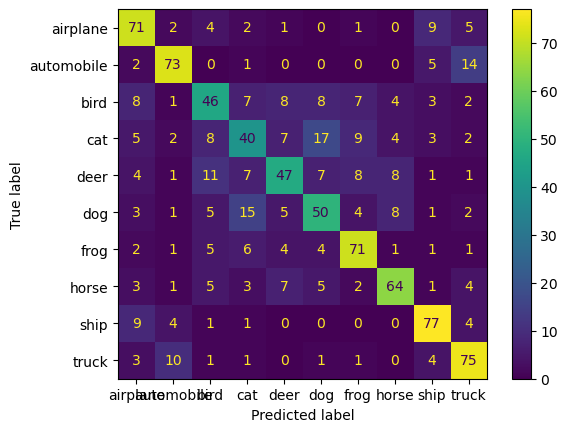

Simple model confusion matrix:


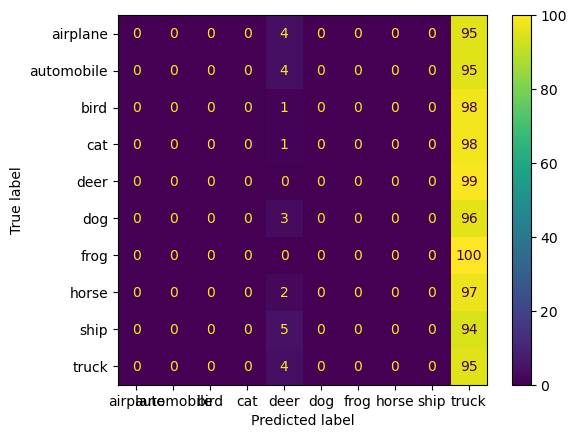

In [19]:
# Compute accuracy and confusion matrix
y_pred_t = torch.cat(y_pred) #Deep CNN
y_gt_t = torch.cat(y_gt)

y_pred_s_t = torch.cat(y_pred_s) #Simple CNN
y_gt_s_t = torch.cat(y_gt_s)    

accuracy = sum(y_pred_t == y_gt_t)/len(y_gt_t)
accuracy_s = sum(y_pred_s_t == y_gt_s_t)/len(y_gt_s_t)
print(f'Deep model Accuracy: {accuracy}')
print(f'Simple model Accuracy: {accuracy_s}')

cm = metrics.confusion_matrix(y_gt_t.cpu(), y_pred_t.cpu()) # confusion matrix
cm_s = metrics.confusion_matrix(y_gt_s_t.cpu(), y_pred_s_t.cpu()) # confusion matrix simple model
cmn = cm.astype(np.float32) 
cmn/=cmn.sum(1) # row-wise sum
cmn_s = cm_s.astype(np.float32)
cmn_s/=cmn_s.sum(1) # row-wise sum simple model

print("Deep model confusion matrix:")
cmn = (100*cmn).astype(np.int32)
disp = metrics.ConfusionMatrixDisplay(cmn, display_labels=testset.classes)
disp.plot()
plt.show()

print("Simple model confusion matrix:")
cmn_s = (100*cmn_s).astype(np.int32)
disp_s = metrics.ConfusionMatrixDisplay(cmn_s, display_labels=testset.classes)
disp_s.plot()
plt.show()

In [21]:
# Compute per-class accuracy from confusion matrix
cmn = cm.astype(np.float32)
cmn/=cmn.sum(1)
print(f'Per class accuracy deep model: {np.diag(cmn).mean():.4f}')

cmn_s = cm_s.astype(np.float32)
cmn_s/=cmn_s.sum(1)
print(f'Per class accuracy simple model: {np.diag(cmn_s).mean():.4f}')

Per class accuracy deep model: 0.6189
Per class accuracy simple model: 0.0963


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].


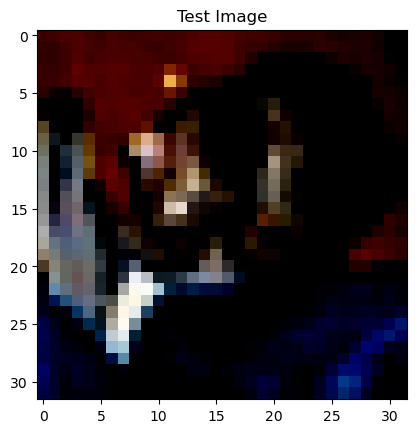

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


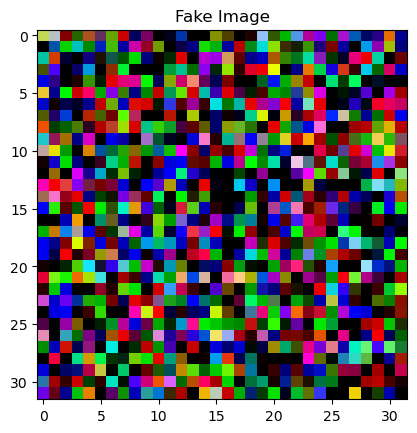

In [22]:
# Show a sample from test and fake datasets
for data in testloader:
    x, y = data
    plt.imshow(x[0,:].permute(1,2,0))
    plt.title('Test Image')
    plt.show()
    break

for data in fakeloader:
    xfake, _ = data
    plt.imshow(xfake[0,:].permute(1,2,0))  
    plt.title('Fake Image') 
    plt.show()
    break




GT: 9, truck
plot logit and softmax of the deep model


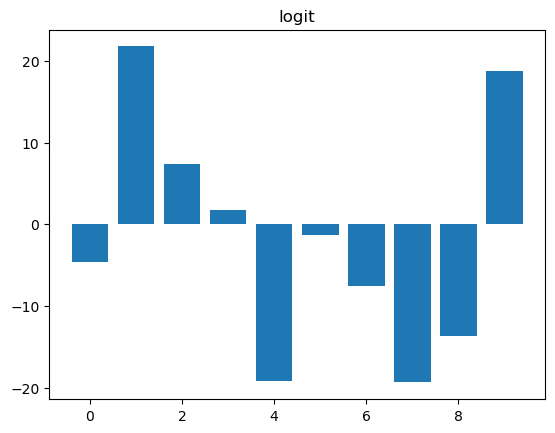

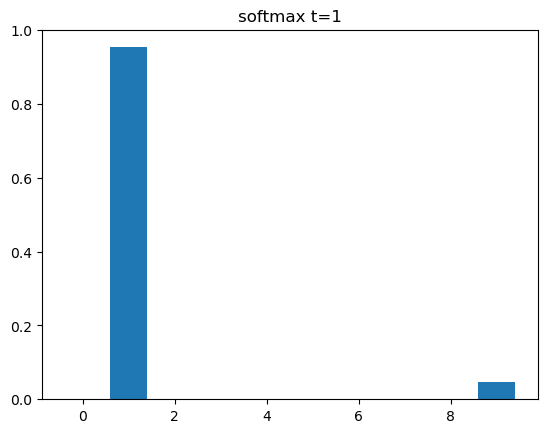

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..1.0].


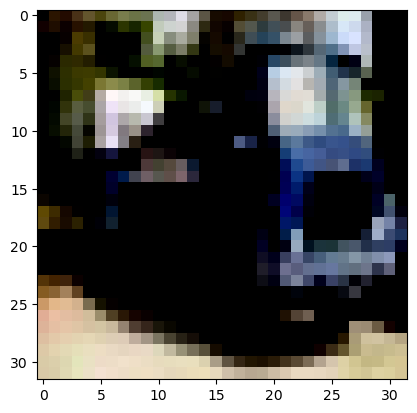

In [ ]:
#Example of logit and softmax output with real data
k=random.randint(0,x.shape[0]) # kth sample of the batch
print(f'GT: {y[k]}, {testset.classes[y[k]]}')# the label of the kth sample
output = model(x.cuda())
print("plot logit and softmax of the deep model")
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1 #Temperature for the softmax
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.title(f'softmax t={T}')
plt.show()

# Plot the kth sample
plt.imshow(x[k,:].permute(1,2,0))
plt.show()


    

GT: 1, automobile
plot logit and softmax of the simple model


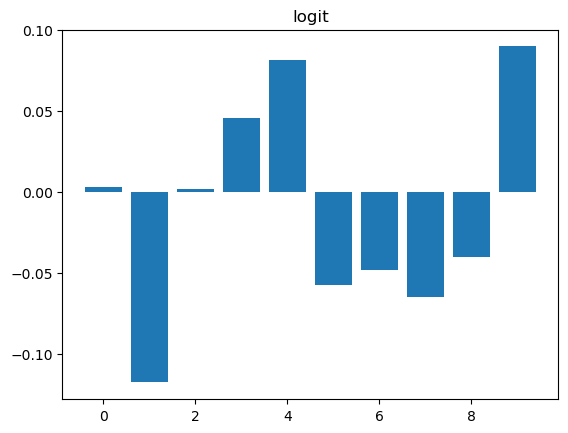

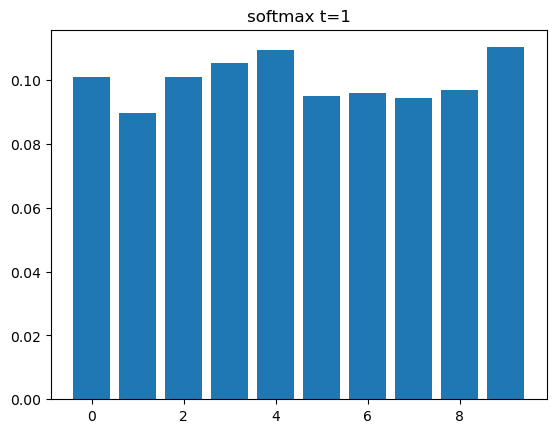

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


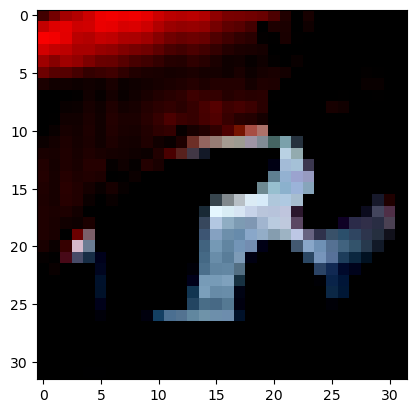

In [ ]:
#Example of logit and softmax output with real data
k=random.randint(0,x.shape[0]) # kth sample of the batch
print(f'GT: {y[k]}, {testset.classes[y[k]]}')# the label of the kth sample
output = simple_model(x.cuda())
print("plot logit and softmax of the simple model")
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1 #Temperature for the softmax
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.title(f'softmax t={T}')
plt.show()

# Plot the kth sample
plt.imshow(x[k,:].permute(1,2,0))
plt.show()


    

In [21]:
x.shape

torch.Size([128, 3, 32, 32])

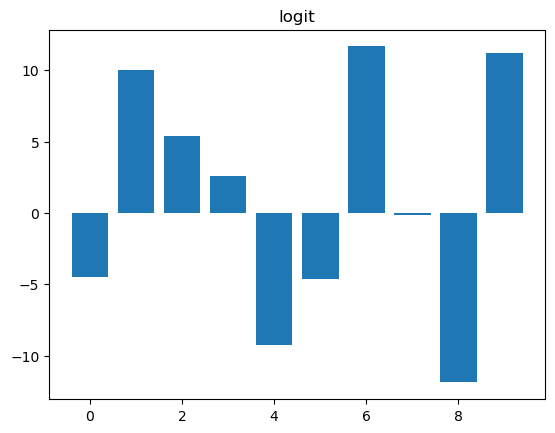

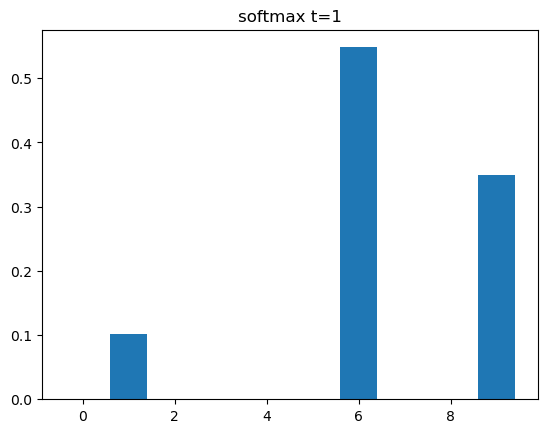

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


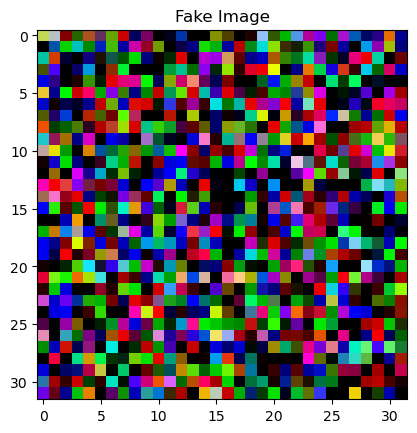

In [25]:
#Example of logit and softmax output with fake data
k=0
output = model(xfake.cuda()) #the kth sample of the batch (fake data)
# Plot logit and softmax
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.show()

plt.imshow(xfake[0,:].permute(1,2,0)) # Fake image has no label
plt.title('Fake Image')
plt.show()


    

plot logit and softmax of the simple model


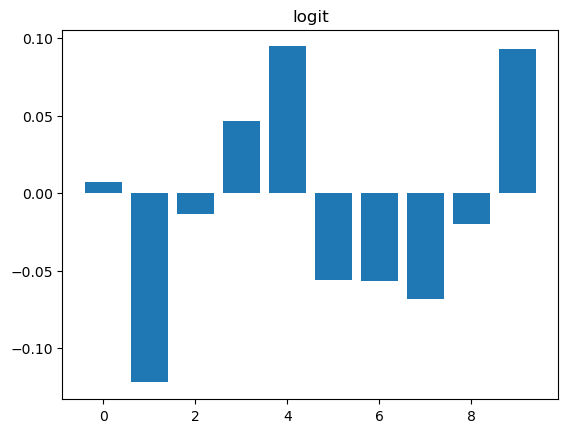

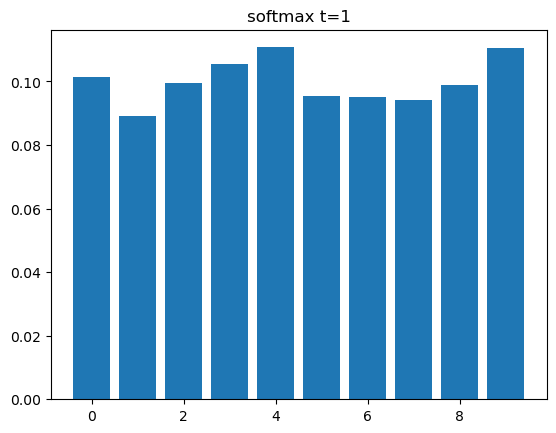

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


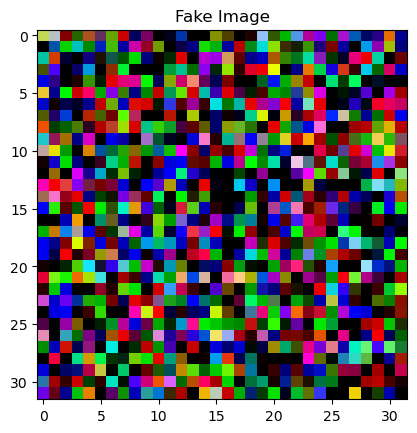

In [26]:
#Example of logit and softmax output with fake data
k=0
output = simple_model(xfake.cuda()) #the kth sample of the batch (fake data)
print("plot logit and softmax of the simple model")
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.show()

plt.imshow(xfake[0,:].permute(1,2,0)) # Fake image has no label
plt.title('Fake Image')
plt.show()


    

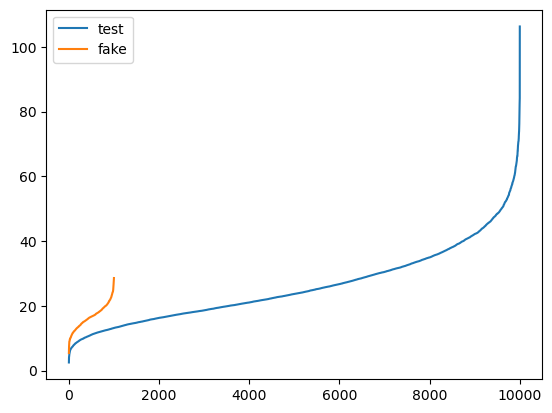

Simple model OOD detection with max logit scores


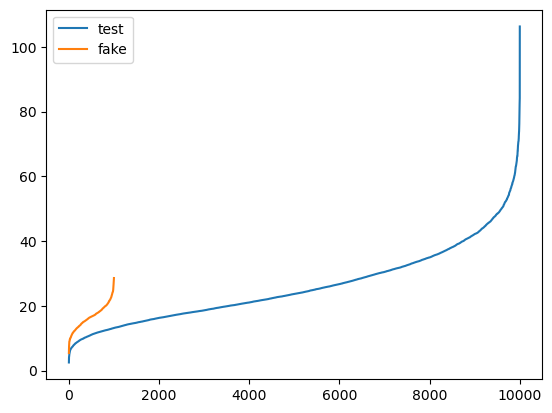

ResNet OOD detection with max logit scores


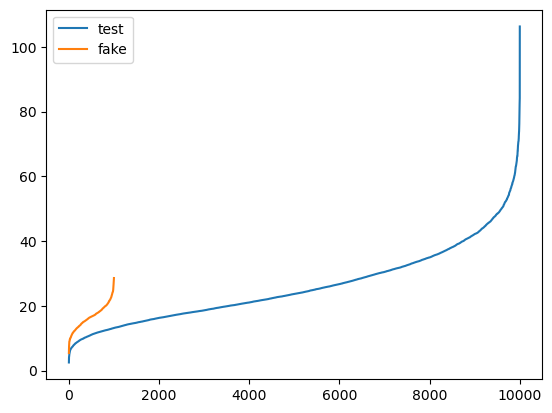

In [29]:
# OOD detection with max logit/max softmax scores
# thw model should be more "confident" on in-distribution data than on OOD data
def max_logit(logit):
    """"
    Compute the maximum logit score for each sample in the batch.
    Args:
        logit (torch.Tensor): The input logits of shape (batch_size, num_classes).
    Returns:
        torch.Tensor: The maximum logit score for each sample in the batch of shape (batch_size,).
    """
    s = logit.max(dim=1)[0] #get the max for each element of the batch
    return s

def max_softmax(logit, T=1.0):
    """
    Compute the maximum softmax score for each sample in the batch.
    Args:
        logit (torch.Tensor): The input logits of shape (batch_size, num_classes).
        T (float): Temperature parameter for scaling the logits before applying softmax.
    Returns:
        torch.Tensor: The maximum softmax score for each sample in the batch of shape (batch_size,).
    """
    s = F.softmax(logit/T, 1)
    s = s.max(dim=1)[0] #get the max for each element of the batch
    return s

def compute_scores(data_loader, score_fun, model=model):
    """ 
    Compute scores for all samples in a dataloader using a given scoring function.
    Args:
        data_loader (torch.utils.data.DataLoader): DataLoader for the dataset.
        score_fun (function): Function to compute the score from model outputs.
        model (torch.nn.Module): The neural network model to use for predictions.
    Returns:
        torch.Tensor: Tensor containing scores for all samples in the dataloader.
    """
    scores = []
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            output = model(x.to(device))
            s = score_fun(output)
            scores.append(s)
        scores_t = torch.cat(scores)
        return scores_t

temp=1
scores_test = compute_scores(testloader, max_logit) # score_fun = max_logit
scores_fake = compute_scores(fakeloader, max_logit)

# Plot sorted scores for test and fake data   
# x --> Sample ordered by score value, y --> OOD score     
plt.plot(sorted(scores_test.cpu()),label='test')
plt.plot(sorted(scores_fake.cpu()),label='fake')
plt.legend()
plt.show()
print("Simple model OOD detection with max logit scores")
scores_test_simple = compute_scores(testloader, max_logit, model=simple_model) # score_fun = max_logit
scores_fake_simple = compute_scores(fakeloader, max_logit, model=simple_model)
# x --> Sample ordered by score value, y --> OOD score     
plt.plot(sorted(scores_test.cpu()),label='test')
plt.plot(sorted(scores_fake.cpu()),label='fake')
plt.legend()
plt.show()
print("ResNet OOD detection with max logit scores")
scores_test_resnet = compute_scores(testloader, max_logit, model=model_resnet) # score_fun = max_logit
scores_fake_resnet = compute_scores(fakeloader, max_logit, model=model_resnet)
# x --> Sample ordered by score value, y --> OOD score     
plt.plot(sorted(scores_test.cpu()),label='test')
plt.plot(sorted(scores_fake.cpu()),label='fake')
plt.legend()
plt.show()

Deep model histogram


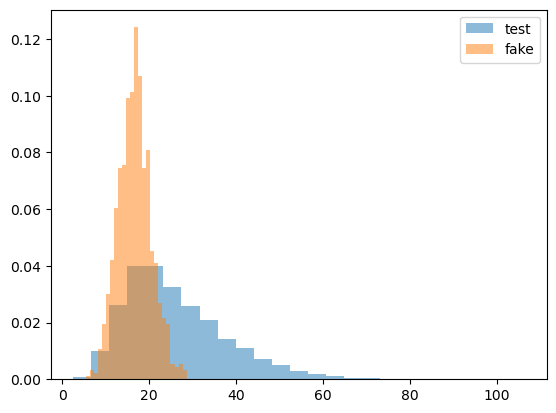

Simple model histogram


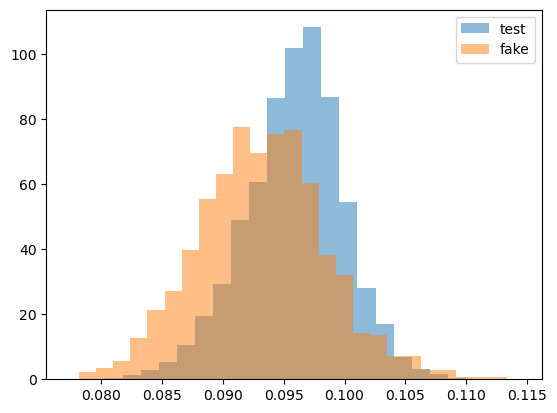

ResNet histogram


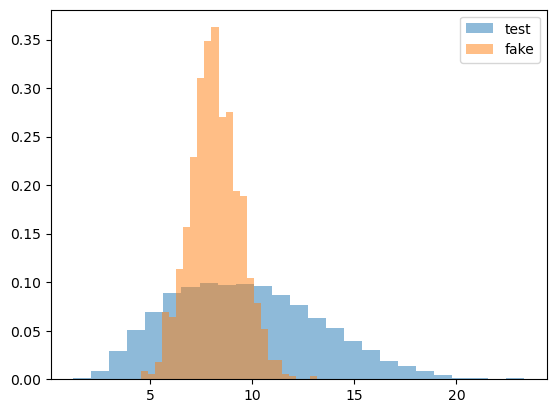

In [28]:
# x --> scores, y --> probability density, alpha --> transparency
print("Deep model histogram")
plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25,label='test')
plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25,label='fake')
plt.legend()
plt.show()

print("Simple model histogram")
plt.hist(scores_test_simple.cpu(), density=True, alpha=0.5, bins=25,label='test')
plt.hist(scores_fake_simple.cpu(), density=True, alpha=0.5, bins=25,label='fake')
plt.legend()
plt.show()

print("ResNet histogram")
plt.hist(scores_test_resnet.cpu(), density=True, alpha=0.5, bins=25,label='test')
plt.hist(scores_fake_resnet.cpu(), density=True, alpha=0.5, bins=25,label='fake')
plt.legend()
plt.show()

In [30]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        """
        Define the architecture of the autoencoder.
        The encoder compresses the input image into a lower-dimensional representation,
        and the decoder reconstructs the image from this representation."""
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [31]:
model_ae = Autoencoder().to(device)

mse_loss =  nn.MSELoss() # difference between the input and the output of the autoencoder (the reconstructed version of the input)
optimizer = optim.Adam(model_ae.parameters(), lr=0.0001)


In [32]:
# train the autoencoder
epochs = 20
for e in range(epochs):
    running_loss = 0
    for it, data in enumerate (trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)
        
        z, x_rec = model_ae(x)
        l = mse_loss(x, x_rec)
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        running_loss += l.item()
        #if it % 100 == 0:
        #    print(it, l.item())
    print(f"epoch: {e}, loss: {running_loss/len(trainloader):.4f}, lr: {optimizer.param_groups[0]['lr']}")
    

epoch: 0, loss: 0.3194, lr: 0.0001
epoch: 1, loss: 0.2023, lr: 0.0001
epoch: 2, loss: 0.1916, lr: 0.0001
epoch: 3, loss: 0.1809, lr: 0.0001
epoch: 4, loss: 0.1725, lr: 0.0001
epoch: 5, loss: 0.1689, lr: 0.0001
epoch: 6, loss: 0.1666, lr: 0.0001
epoch: 7, loss: 0.1642, lr: 0.0001
epoch: 8, loss: 0.1613, lr: 0.0001
epoch: 9, loss: 0.1594, lr: 0.0001
epoch: 10, loss: 0.1582, lr: 0.0001
epoch: 11, loss: 0.1572, lr: 0.0001
epoch: 12, loss: 0.1563, lr: 0.0001
epoch: 13, loss: 0.1555, lr: 0.0001
epoch: 14, loss: 0.1549, lr: 0.0001
epoch: 15, loss: 0.1543, lr: 0.0001
epoch: 16, loss: 0.1538, lr: 0.0001
epoch: 17, loss: 0.1534, lr: 0.0001
epoch: 18, loss: 0.1530, lr: 0.0001
epoch: 19, loss: 0.1527, lr: 0.0001


In [33]:
model_ae.eval()
#use negative MSE since higher error means OOD --> higher score for OOD
loss = nn.MSELoss(reduction='none')

scores_fake_ae = []
with torch.no_grad():
    for data in fakeloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x) #z --> encoded version, xr --> reconstructed version
        l = loss(x, xr)
        score = l.mean([1,2,3]) # mean over channels and spatial dimensions
        scores_fake_ae.append(-score)
        
scores_fake_ae = torch.cat(scores_fake_ae)



scores_test_ae = []
with torch.no_grad():
    for data in testloader:
        x, y = data
        x=x.to(device)
        z, xr = model_ae(x)
        l = loss(x, xr)
        score = l.mean([1,2,3])
        scores_test_ae.append(-score)
        
scores_test_ae = torch.cat(scores_test_ae)



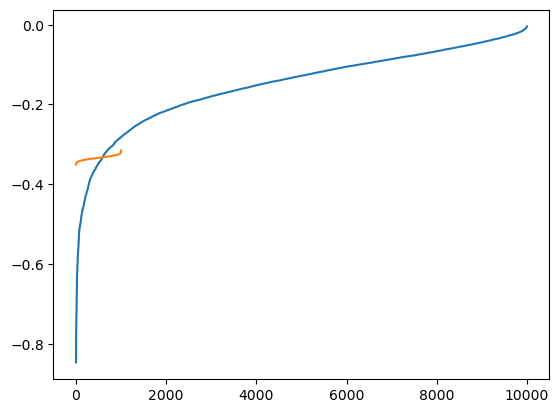

In [34]:
plt.plot(sorted(scores_test_ae.cpu())) # x--> samples sorted by score, y --> score
plt.plot(sorted(scores_fake_ae.cpu()))


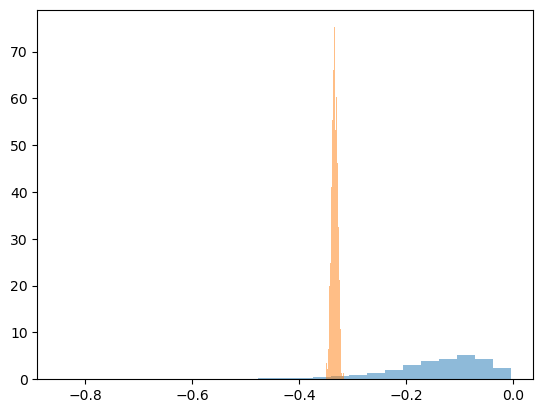

In [35]:
plt.hist(scores_test_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.hist(scores_fake_ae.cpu(), density=True, alpha=0.5, bins=25)
plt.show()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)



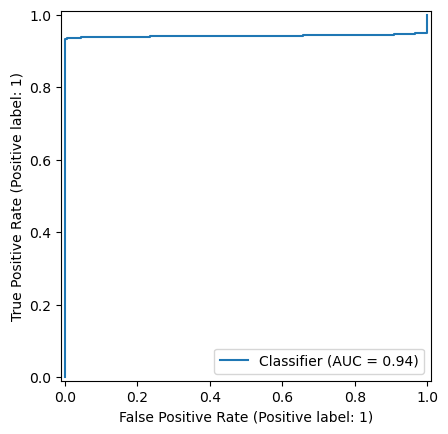

In [36]:
#AE performance
ypred =  torch.cat((scores_test_ae, scores_fake_ae))
y_test = torch.ones_like(scores_test_ae)
y_fake = torch.zeros_like(scores_fake_ae)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

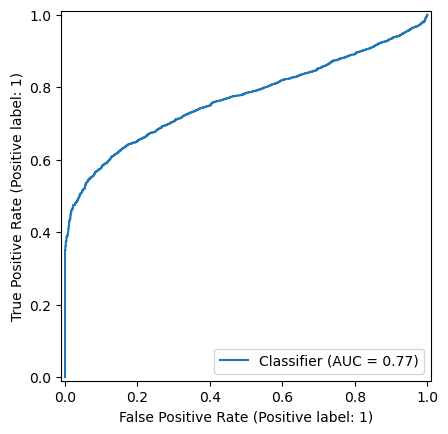

In [37]:
#logits or softmax performance
ypred = torch.cat((scores_test, scores_fake))
y_test = torch.ones_like(scores_test)
y_fake = torch.zeros_like(scores_fake)

y = torch.cat((y_test, y_fake))

#y.shape
metrics.RocCurveDisplay.from_predictions(y.cpu(), ypred.cpu())

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [38]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

inv = NormalizeInverse((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [39]:
for i,c in enumerate(testset.classes):
    print(i, c)

0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098028..1.0000001].


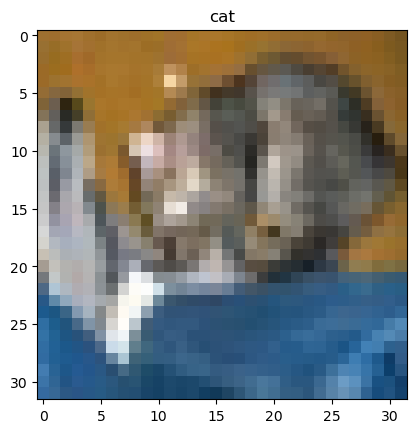

Attack!!
target: deer
3 3
3 3
4 3
Targeted attack(deer) success! budget:3/255


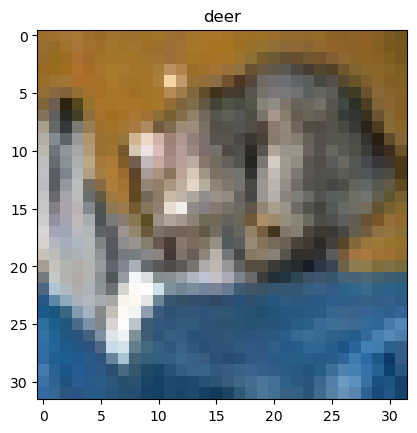

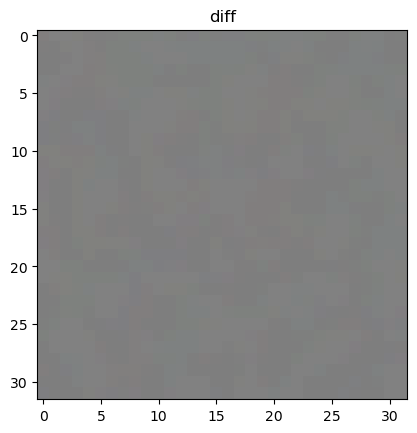

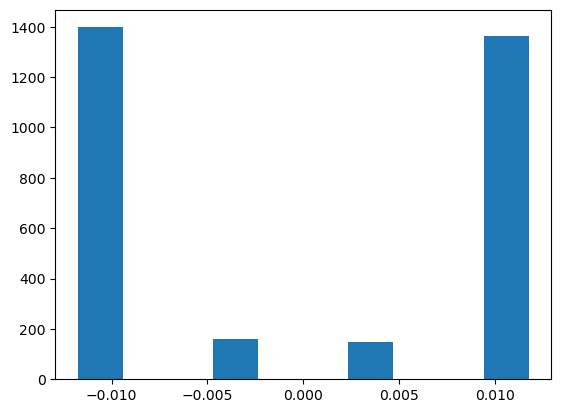

In [40]:
loss =  nn.CrossEntropyLoss()
model.train()
for data in testloader:
    x, y = data
    break
##########CONFIG###########

targeted_attack = True
target_label = class_dict['deer'] # target class for targeted attack
eps = 1/255 #set the budget for each step
sample_id = 0 #select id of test set sample to try to attack

#########END##############

x,y = x[sample_id].to(device), y[sample_id].to(device)

x = x[None,:]
y = y[None]

x.requires_grad=True  
#print(x)

before = x.clone() # save the original image to compute the difference later
output=model(x)
#print(output.argmax().item(),  y.item())
img = inv(x[0])
plt.imshow(img.permute(1,2,0).detach().cpu())
plt.title(testset.classes[output.argmax()])
plt.show()

if output.argmax().item()!=  y.item() or y.item()==target_label:
    print('classifier is already wrong or target label same as GT!')
else:
    done = False
    print('Attack!!')
    n=0
    #only attack if y==model(x)
    #target=torch.tensor(y).unsqueeze(0).cuda()
    if targeted_attack:
        target=torch.tensor(target_label).unsqueeze(0).cuda()
        print(f'target: {testset.classes[target.squeeze()]}')
   
    while not done: #untargeted attack until success!
    

        x.retain_grad()

        output=model(x)

        model.zero_grad()
        if targeted_attack:
            yt=target#targeted, we want the model to predict the target class
        else:
            yt=y #untargeted, we want the model to misclassify the original class
        
        l = loss(output,yt)
        l.backward()

        
        if targeted_attack:
            x = x - eps*torch.sign(x.grad)#fgsm targeted, minimize the loss w.r.t. the target class
        else:
            x = x + eps*torch.sign(x.grad)#fgsm untargeted, maximize the loss w.r.t. the original class
        n+=1

        print(output.argmax().item(),  y.item())
        if not targeted_attack and output.argmax().item()!=  y.item():
            #success if  the predicted class is different from the original class
            print(f'Untargeted attack success! budget:{int(255*n*eps)}/255')
            done=True
        
        if targeted_attack and output.argmax().item() == target:
            #success if the predicted class is the target class
            print(f'Targeted attack({testset.classes[output.argmax()]}) success! budget:{int(255*n*eps)}/255')
            done=True
            
   
    img = inv(x.squeeze())
    plt.imshow(img.permute(1,2,0).detach().cpu())
    plt.title(testset.classes[output.argmax()])
    plt.show()

    diff = (x-before) # difference between the original and the adversarial image
    diffi = inv(diff[0]) # bring the difference back to the input domain
    plt.imshow(diffi.permute(1,2,0).detach().cpu())
    plt.title('diff')
    plt.show()

    diff_flat = diff.flatten()

    plt.hist(diff_flat.detach().cpu())
    






In [41]:
x.shape

torch.Size([1, 3, 32, 32])

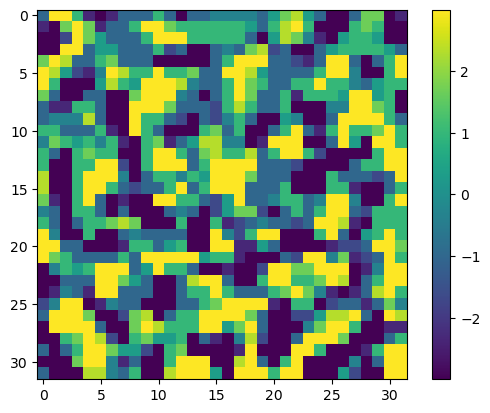

In [42]:
# plot the mean difference image
diff.squeeze().mean(0).shape
plt.imshow(255*diff.cpu().detach().squeeze().mean(0))
plt.colorbar()

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [43]:
# Your code here.
def fgsm(model, x, y, eps, targeted=False, target_class=None):
    """
    Perform the Fast Gradient Sign Method (FGSM) attack on a batch of images.
    Args:
        model (torch.nn.Module): The neural network model to attack.
        x (torch.Tensor): The input images of shape (batch_size, channels, height, width).
        y (torch.Tensor): The true labels of the input images of shape (batch_size,).
        eps (float): The perturbation budget.
        targeted (bool): If True, perform a targeted attack; otherwise, perform an untargeted attack.
        target_class (int, optional): The target class for targeted attacks. Required if targeted is True.
    Returns:
        torch.Tensor: The perturbed images of the same shape as the input images.
    """
    x_perturbed = x.clone().detach().requires_grad_(True)
    output = model(x_perturbed)
    if targeted and target_class is not None:
        loss_fn = nn.CrossEntropyLoss()
        target = torch.full_like(y, target_class)
    else:
        target = y
    
    loss = F.cross_entropy(output, target)
    loss.backward()

    with torch.no_grad():
        if targeted:
            perturbed = x_perturbed - eps * torch.sign(x_perturbed.grad)
        else:
            perturbed = x_perturbed + eps * torch.sign(x_perturbed.grad)
    return perturbed

In [44]:
model_adv_aug = DeepCNN().to(device)
# Training loop with adversarial augmentation
model_adv_aug.train()
epochs = 50
eps = 1/255  # budget for FGSM

for epoch in range(epochs):
    running_loss = 0
    for it, data in enumerate(trainloader):
        x, y = data
        x, y = x.to(device), y.to(device)
        
        # Generate adversarial examples for half of the batch
        batch_size = x.shape[0]
        split = batch_size // 2
        x_clean = x[:split]
        x_adv = fgsm(model, x[split:], y[split:], eps)
        
        # Concat clean and adversarial examples
        x_combined = torch.cat([x_clean, x_adv])
        y_combined = y  # same labels for both clean and adversarial examples
        
        # Forward eand backward pass
        optimizer.zero_grad()
        output = model(x_combined)
        l = loss(output, y_combined)
        l.backward()
        optimizer.step()
        
        running_loss += l.item()
        
    print(f"epoch: {epoch}, loss: {running_loss/len(trainloader):.4f}")

epoch: 0, loss: 0.0849
epoch: 1, loss: 0.0856
epoch: 2, loss: 0.0850
epoch: 3, loss: 0.0843
epoch: 4, loss: 0.0846
epoch: 5, loss: 0.0857
epoch: 6, loss: 0.0850
epoch: 7, loss: 0.0850
epoch: 8, loss: 0.0850
epoch: 9, loss: 0.0866
epoch: 10, loss: 0.0869
epoch: 11, loss: 0.0857
epoch: 12, loss: 0.0850
epoch: 13, loss: 0.0851
epoch: 14, loss: 0.0847
epoch: 15, loss: 0.0841
epoch: 16, loss: 0.0871
epoch: 17, loss: 0.0872
epoch: 18, loss: 0.0856
epoch: 19, loss: 0.0880
epoch: 20, loss: 0.0855
epoch: 21, loss: 0.0873
epoch: 22, loss: 0.0879
epoch: 23, loss: 0.0855
epoch: 24, loss: 0.0846
epoch: 25, loss: 0.0847
epoch: 26, loss: 0.0860
epoch: 27, loss: 0.0863
epoch: 28, loss: 0.0844
epoch: 29, loss: 0.0853
epoch: 30, loss: 0.0880
epoch: 31, loss: 0.0850
epoch: 32, loss: 0.0868
epoch: 33, loss: 0.0863
epoch: 34, loss: 0.0854
epoch: 35, loss: 0.0857
epoch: 36, loss: 0.0869
epoch: 37, loss: 0.0853
epoch: 38, loss: 0.0855
epoch: 39, loss: 0.0839
epoch: 40, loss: 0.0851
epoch: 41, loss: 0.0856
ep

GT: 0, airplane


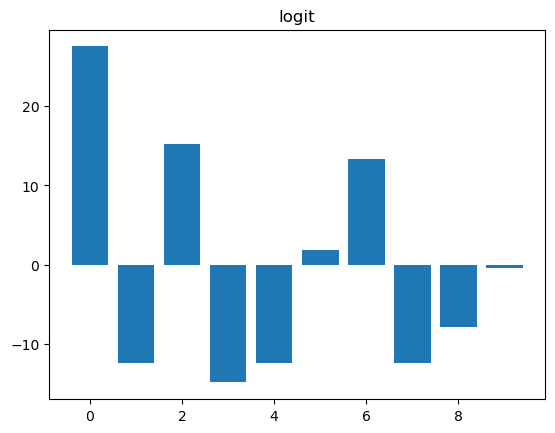

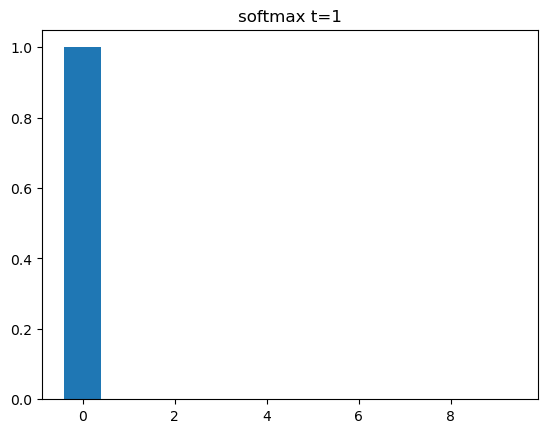

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.73333335].


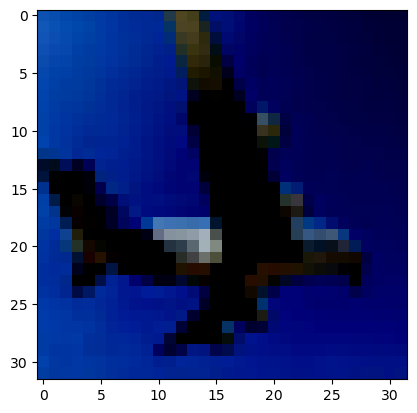

In [45]:
k=random.randint(0,x.shape[0])
print(f'GT: {y[k]}, {testset.classes[y[k]]}')#the corresponding label --> select a random sample from the batch
output = model(x.cuda())
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1 #Temperature for the softmax
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.title(f'softmax t={T}')
plt.show()

plt.imshow(x[k,:].cpu().permute(1,2,0))
plt.show()

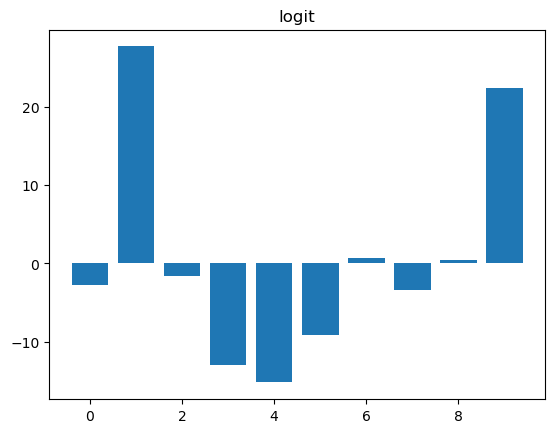

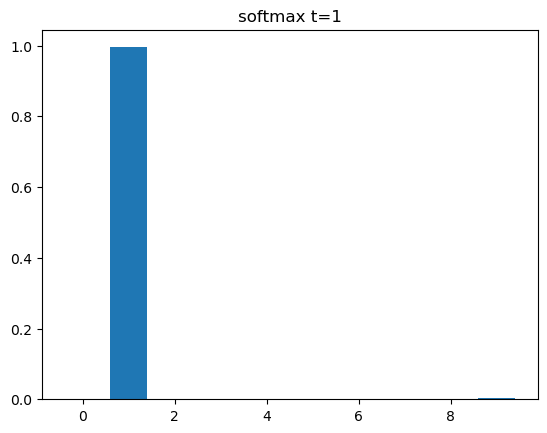

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


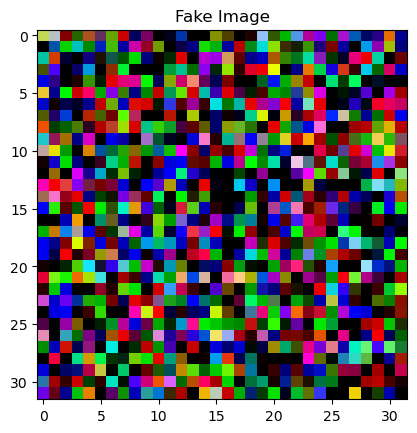

In [46]:
#Example of logit and softmax output with fake data
k=2
output = model(xfake.cuda()) #the kth sample of the batch (fake data)
plt.bar(np.arange(10),output[k].detach().cpu())
plt.title('logit')
plt.show()
T=1
plt.title(f'softmax t={T}')
s = F.softmax(output/T, 1)
plt.bar(np.arange(10),s[k].detach().cpu())
plt.show()

plt.imshow(xfake[0,:].permute(1,2,0)) #fake image has no label
plt.title('Fake Image')
plt.show()


    

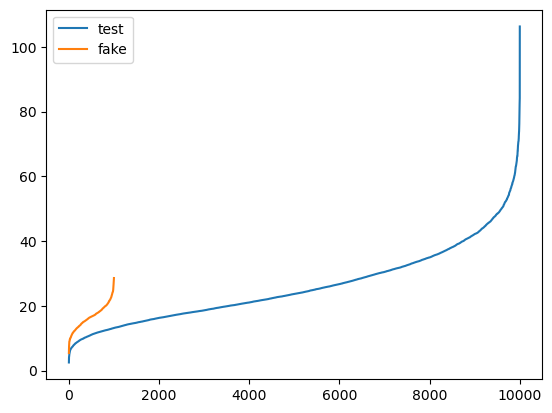

In [47]:
scores_test = compute_scores(testloader, max_logit)
scores_fake = compute_scores(fakeloader, max_logit)

        
plt.plot(sorted(scores_test.cpu()),label='test')
plt.plot(sorted(scores_fake.cpu()),label='fake')
plt.legend()

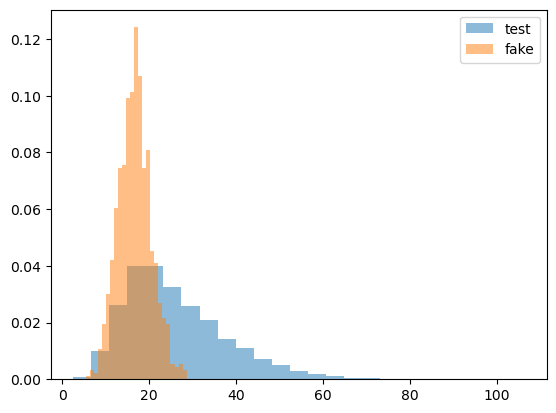

In [48]:
# x --> scores, y --> probability density, alpha --> transparency
plt.hist(scores_test.cpu(), density=True, alpha=0.5, bins=25,label='test')
plt.hist(scores_fake.cpu(), density=True, alpha=0.5, bins=25,label='fake')
plt.legend()
plt.show()


FGSM augmentation can reduce OOD detection robustness due to three main factors: 
(1) it may induce overconfidence on spurious patterns, as adversarial examples seen during training remain close to the original distribution; 
(2) adversarial training tends to overly smooth decision boundaries, making the model assign high confidence even to truly OOD samples;
(3) while it improves robustness to attacks, it often worsens calibration, reducing the reliability of confidence estimates for OOD detection.

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


Exercise 3.1

In [49]:
def softmax_with_temp(logits, T=1.0):
    """"
    Apply softmax with temperature scaling.
    Args:
        logits (torch.Tensor): The input logits of shape (batch_size, num_classes).
        T (float): Temperature parameter for scaling the logits.
    Returns:
        torch.Tensor: The softmax probabilities of shape (batch_size, num_classes).
    """
    return F.softmax(logits / T, dim=1)

def perturb_input(model, x, T=1.0, epsilon=0.001):
    """
    Perturb the input image using the ODIN method.
    Args:
        model (torch.nn.Module): The neural network model.
        x (torch.Tensor): The input images of shape (batch_size, channels, height, width).
        T (float): Temperature parameter for scaling the logits.
        epsilon (float): The perturbation magnitude.
    Returns:
        torch.Tensor: The perturbed images of the same shape as the input images.
    """
    x.requires_grad = True
    logits = model(x)
    pred = softmax_with_temp(logits, T)
    # Select the class with the highest softmax probability
    label = pred.max(1)[1]
    loss = F.cross_entropy(logits / T, label)
    loss.backward()
    # Perturb the input in the direction that maximizes the loss
    delta = epsilon * x.grad.data.sign()
    x_perturbed = x.data - delta
    return x_perturbed

def odin_score(model, x, T=1.0, epsilon=0.001):
    """
    Compute the ODIN score for a batch of images.
    Args:
        model (torch.nn.Module): The neural network model.
        x (torch.Tensor): The input images of shape (batch_size, channels, height, width).
        T (float): Temperature parameter for scaling the logits.
        epsilon (float): The perturbation magnitude.
    Returns:
        np.ndarray: The ODIN scores for each sample in the batch.
    """
    x_pert = perturb_input(model, x, T, epsilon)
    logits = model(x_pert)
    probs = softmax_with_temp(logits, T)
    conf, _ = probs.max(1)
    return conf.detach().cpu().numpy()


In [ ]:
temperatures = [1, 10, 100]
epsilons = [0.0, 0.001, 0.002, 0.004]

transform = transforms.Compose([
    transforms.ToTensor(),
])

# ID = CIFAR10 testloader 
id_loader = testloader

# OOD = SVHN test set
ood_dataset = datasets.SVHN(root="./data", split="test", download=True, transform=transform) # OOD dataset
ood_loader = torch.utils.data.DataLoader(ood_dataset, batch_size=64, shuffle=False)
results = {}

# Evaluate ODIN scores for different T and epsilon values
for T in temperatures:
    for eps in epsilons:
        id_scores, ood_scores = [], []

        for x, _ in tqdm(id_loader, desc=f"T={T}, eps={eps}, ID"):
            x = x.cuda()
            scores = odin_score(model, x, T, eps)
            id_scores.extend(scores)

        for x, _ in tqdm(ood_loader, desc=f"T={T}, eps={eps}, OOD"):
            x = x.cuda()
            scores = odin_score(model, x, T, eps)
            ood_scores.extend(scores)

        
        y_true = np.array([1]*len(id_scores) + [0]*len(ood_scores))
        y_score = np.array(id_scores + ood_scores)
        auroc = roc_auc_score(y_true, y_score)
        
        results[(T, eps)] = auroc

# Best parameters
best = max(results, key=results.get)
print("Migliori T, eps:", best, "AUROC:", results[best])


100%|██████████| 64.3M/64.3M [00:20<00:00, 3.21MB/s]
T=100, eps=0.004, OOD: 100%|██████████| 407/407 [00:18<00:00, 22.57it/s]

Migliori T, eps: (100, 0.004) AUROC: 0.8914008700829748


In [51]:
def plot_scores(id_scores, ood_scores, best):
    """
    Plot the histograms of ODIN scores for in-distribution and out-of-distribution data.
    Args:
        id_scores (list): List of ODIN scores for in-distribution data.
        ood_scores (list): List of ODIN scores for out-of-distribution data.
        best (tuple): Tuple containing the best (T, epsilon) values.
    """
    best_T, best_eps = best
    plt.figure(figsize=(8,5))
    plt.hist(id_scores, bins=50, alpha=0.6, label="In-Distribution (CIFAR10)", density=True)
    plt.hist(ood_scores, bins=50, alpha=0.6, label="Out-of-Distribution", density=True)
    plt.xlabel("ODIN confidence score")
    plt.ylabel("Density")
    plt.legend()
    plt.title(f"ODIN scores - T={best_T}, ε={best_eps}")
    plt.show()

In [52]:
# Same but with the adversarially trained model
results2 = {}
for T in temperatures:
    for eps in epsilons:
        id_scores2, ood_scores2 = [], []

        for x, _ in tqdm(id_loader, desc=f"T={T}, eps={eps}, ID"):
            x = x.cuda()
            scores = odin_score(model_adv_aug, x, T, eps)
            id_scores2.extend(scores)

        for x, _ in tqdm(ood_loader, desc=f"T={T}, eps={eps}, OOD"):
            x = x.cuda()
            scores = odin_score(model_adv_aug, x, T, eps)
            ood_scores2.extend(scores)

        y_true = np.array([1]*len(id_scores2) + [0]*len(ood_scores2))
        y_score = np.array(id_scores2 + ood_scores2)
        auroc = roc_auc_score(y_true, y_score)
        
        results2[(T, eps)] = auroc

# Best parameters for adversarially trained model
best2 = max(results, key=results.get)
print("Migliori T, eps:", best, "AUROC:", results2[best2])

T=100, eps=0.004, OOD: 100%|██████████| 407/407 [00:17<00:00, 22.85it/s]

Migliori T, eps: (100, 0.004) AUROC: 0.867031929932391


Standard trained model:


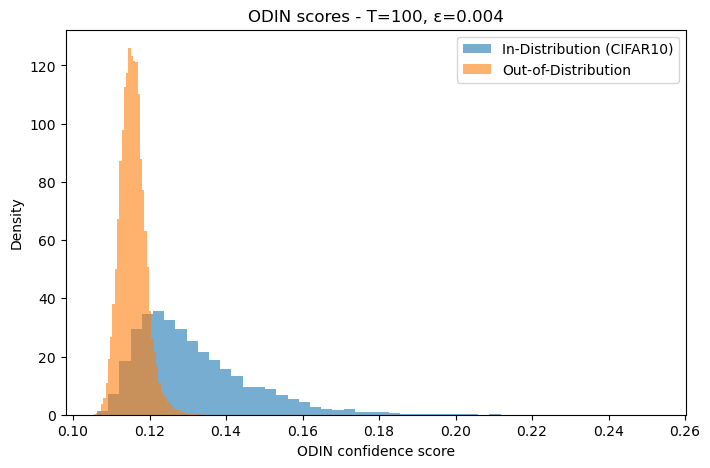

Adversarially trained model:


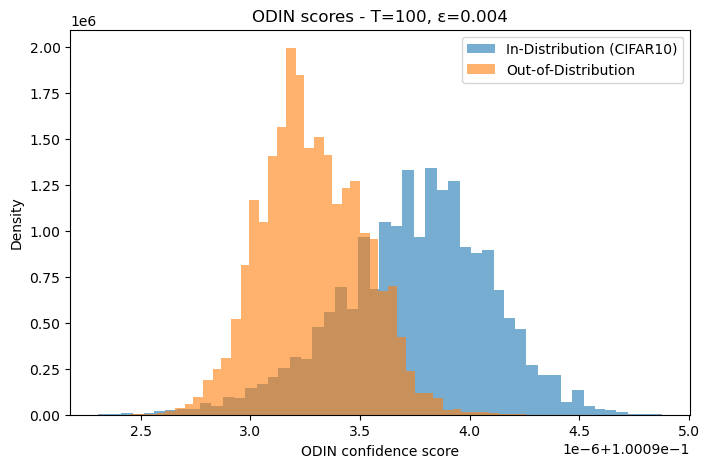

In [53]:
print("Standard trained model:")
plot_scores(id_scores, ood_scores, best)
print("Adversarially trained model:")
plot_scores(id_scores2, ood_scores2, best2)